In [1]:
Threads.nthreads()

8

In [2]:
using DifferentialEquations, Plots, LaTeXStrings

In [3]:
const Φ₀ = 2.06783383e-15
const ħ = 1.0545718e-34
const Ic = 1.69e-9;

# Capacitively Coupled Parallel RLC Circuit

Kirchoff's voltage law gives us, for each closed loop around the circuit

$$ V(t) = \frac{Q}{C_{CL}} + L \dot{I}_L $$

$$ V(t) = \frac{Q}{C_{CL}} + I_R $$

$$ V(t) = \frac{Q}{C_{CL}} + L \frac{Q_C}{C} $$

Relating these equations gives

$$ L\dot{I}_L = I_R R $$

$$ L\dot{I}_L = \frac{Q_C}{C} $$

Then using Kirchoff's current law, $I = I_C + I_R + I_L$, along with the fact that $I = \frac{dQ}{dt}$  and $ I_C = \frac{dQ_C}{dt}$, we get a second order differential equation for the current in the inductive element

$$ \ddot{I}_L = \frac{-1}{C_c + C}\left(\frac{1}{R} \dot{I}_L + \frac{1}{L} I_L\right) + \frac{\omega V_0 \cos(\omega t)}{L\left(1 + \frac{C}{C_c}\right)} $$

## RLC Model Parameters

In [4]:
const V₀ = 1.0e-3
const Q = 1000.0
const Cc = 0.1e-15
const Cs = 56e-15
const CJ = 7e-15
const C = Cs + CJ
const L = Φ₀ / (2π * Ic);

parallel resistance:

In [5]:
R = Q / sqrt(C / L)

1.758143246919784e6

rosonance frequency:

In [6]:
ω₀ = 1 / sqrt(L * C)

9.028283617290537e9

## Problem Setup

In [7]:
function parallelRLC(ddI, dI, I, ω, t)
    @. ddI = -1 / (Cc + C) * (1 / R * dI + 1 / L * I) + ω * V₀ * cos(ω * t) / (L * (1 + C / Cc))
end;

problem parameters:

In [8]:
tspan = (0.0, 5e-9)
dt = 1e-12;

algorithm:

In [9]:
alg = VerletLeapfrog();

## Demo Solution

In [10]:
driving_frequency = 9e9;

In [11]:
prob = SecondOrderODEProblem(parallelRLC, [0.0], [0.0], tspan, driving_frequency);

In [12]:
sol = solve(prob, alg, dt=dt);

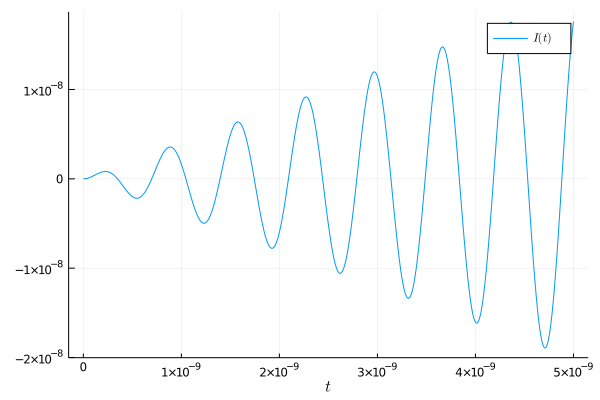

In [13]:
plot(sol.t, sol[2,:], label=L"I(t)", xlabel=L"t")
# plot!(sol.t, sol[1,:], label=L"dI/dt")
# plot!(sol.t, sin.(driving_frequency .* sol.t), label="driving voltage")

## Resonance Sweep

In [50]:
sweeprange = 1e11
ωs = collect(0:1e6:sweeprange);

In [51]:
parallel_peaks = Vector{Float64}(undef, length(ωs))
Threads.@threads for i in 1:length(parallel_peaks)
    problem = SecondOrderODEProblem(parallelRLC, [0.0], [0.0], tspan, ωs[i])
    solution = solve(problem, alg, dt=dt)
    parallel_peaks[i] = maximum(solution[2,:])
end

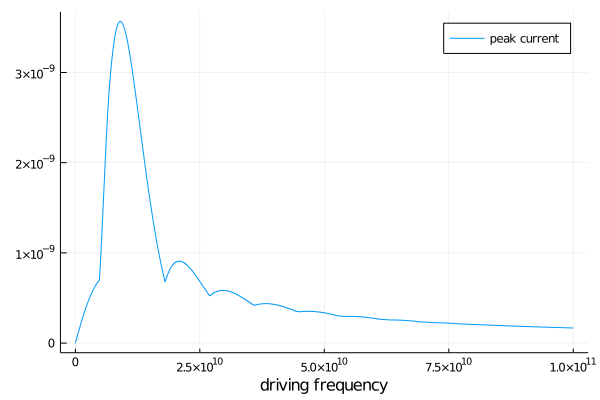

In [52]:
plot(ωs, parallel_peaks, label="peak current", xlabel="driving frequency")

## Series RLC Circuit


$$V(t) = L \dot{I} + I R + C^{-1} Q$$

Taking a derivative with the assumption inductance is time-independent and the current source is given by $V_0 \sin(\omega t)$ we get a second order differential equation for current.

$$\ddot{I} = -\frac{R}{L} \dot{I} - \frac{1}{CL} I + \frac{\omega V_0 \cos(\omega t)}{L}$$


In [53]:
series_R = sqrt(L / C) / Q

1.758143246919784

In [54]:
function seriesRLC(ddI, dI, I, ω, t)
    @. ddI = -series_R / L * dI - 1 / C / L * I + ω * V₀ * cos(ω * t) / L
end;

In [57]:
series_peaks = Vector{Float64}(undef, length(ωs))
Threads.@threads for i in 1:length(ωs)
    problem = SecondOrderODEProblem(seriesRLC, [0.0], [0.0], tspan, ωs[i])
    solution = solve(problem, alg, dt=dt)
    series_peaks[i] = maximum(solution[2,:])
end

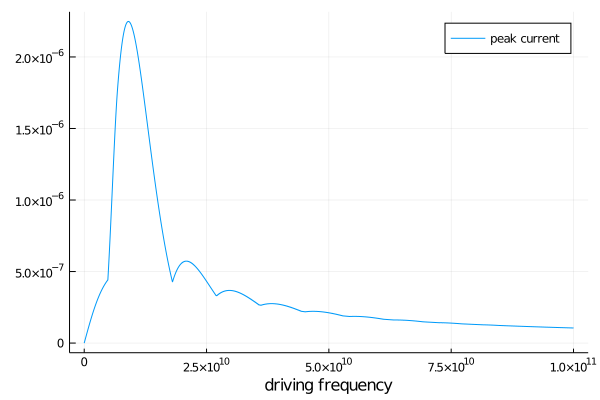

In [58]:
plot(ωs, series_peaks, label="peak current", xlabel="driving frequency")

# Qubit Circuit

By replacing the inductor in the RLC circuit with a Josephson Junction, we get a time-dependent inductance defined as

$$L_J (I_J(t)) = \frac{\Phi_0}{2\pi \sqrt{I_c^2- I_J^2(t)}}$$

Which gives us the following differential equation for the current, $I_J$, in the Josephson Junction

$$\ddot{I}_J = \frac{-1}{C_{CL} + C_{s + J}} \left(\frac{1}{R} \dot{I}_J + \frac{1}{L_J} I_J \right) - \frac{I_J}{I_c^2 - I_J^2} \dot{I}_J^2 + \frac{\omega V_0 \cos(\omega t)}{L_J\left(1 + \frac{C_{s + J}}{C_{CL}}\right)}   $$
          

## Parameters

In [59]:
const Cg = 5.0e-15
const CΣ = Cs + CJ + Cg
const Rn = 14.0e-3
const qubitV₀ = 1.0;

In [60]:
qubit_Q = 1e6
qubit_R = 2e9

2.0e9

## Problem Setup

In [61]:
function qubit(ddI::Vector{Complex{Float64}}, 
               dI::Vector{Complex{Float64}}, 
               I::Vector{Complex{Float64}}, 
               ω, t)
    @. ddI = -1 / (Cc + C) * 
             (1 / R * dI + 1 / (Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * I) - 
             I / (Ic^2 - I^2) * dI^2 + 
             ω * V₀ * cos(ω * t) / 
             ((Φ₀ / (2π * sqrt(Complex(Ic^2 - I^2)))) * (1 + C / Cc))
end;

In [84]:
f01 = 4.1e9
qubit_ωs = collect(1e9:1e6:3e10)
qubit_peaks = Vector{Float64}(undef, length(qubit_ωs))
qubit_alg = VerletLeapfrog();

In [85]:
tspan = (0.0, 1e-9)

(0.0, 1.0e-9)

## Solutions

In [108]:
Threads.@threads for i in 1:length(qubit_ωs)
    problem = SecondOrderODEProblem(qubit, Complex.([0.0]), Complex.([0.0]), tspan, qubit_ωs[i])
    solution = solve(problem, alg, dt=dt, reltol=1e-9, abstol=1e-9)
    qubit_peaks[i] = maximum(abs.(solution[2,:]))
end

LoadError: TaskFailedException:
InterruptException:
Stacktrace:
 [1] Broadcasted at ./broadcast.jl:170 [inlined]
 [2] Broadcasted at ./broadcast.jl:179 [inlined] (repeats 2 times)
 [3] broadcasted at ./broadcast.jl:1265 [inlined]
 [4] broadcasted(::Function, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0},Nothing,typeof(/),Tuple{Int64,Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0},Nothing,typeof(+),Tuple{Float64,Float64}}}}, ::Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(+),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(*),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0},Nothing,typeof(/),Tuple{Int64,Float64}},Array{Complex{Float64},1}}},Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(*),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(/),Tuple{Int64,Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(/),Tuple{Float64,Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(*),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0},Nothing,typeof(*),Tuple{Int64,Irrational{:π}}},Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(sqrt),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,Type{Complex},Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(-),Tuple{Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{0},Nothing,typeof(Base.literal_pow),Tuple{Base.RefValue{typeof(^)},Float64,Base.RefValue{Val{2}}}},Base.Broadcast.Broadcasted{Base.Broadcast.DefaultArrayStyle{1},Nothing,typeof(Base.literal_pow),Tuple{Base.RefValue{typeof(^)},Array{Complex{Float64},1},Base.RefValue{Val{2}}}}}}}}}}}}}}}},Array{Complex{Float64},1}}}}}) at ./broadcast.jl:1263
 [5] qubit(::Array{Complex{Float64},1}, ::Array{Complex{Float64},1}, ::Array{Complex{Float64},1}, ::Float64, ::Complex{Float64}) at ./In[61]:5
 [6] ODEFunction at /home/aaron/.julia/packages/DiffEqBase/m5bAm/src/diffeqfunction.jl:248 [inlined]
 [7] perform_step!(::OrdinaryDiffEq.ODEIntegrator{VerletLeapfrog,true,ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Nothing,Float64,Float64,Float64,Float64,Float64,Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},ODESolution{Complex{Float64},2,Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},Nothing,Nothing,Array{Float64,1},Array{Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},1},ODEProblem{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Tuple{Float64,Float64},true,Float64,DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},SecondOrderODEProblem{true}},VerletLeapfrog,OrdinaryDiffEq.InterpolationData{DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},Array{Float64,1},Array{Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},1},OrdinaryDiffEq.Symplectic2Cache{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},OrdinaryDiffEq.Symplectic2ConstantCache{Complex{Float64},Float64}}},DiffEqBase.DEStats},DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},OrdinaryDiffEq.Symplectic2Cache{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},OrdinaryDiffEq.Symplectic2ConstantCache{Complex{Float64},Float64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(LinearAlgebra.opnorm),CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},Nothing,Nothing,Int64,Tuple{},Tuple{},Tuple{}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Complex{Float64},Nothing,OrdinaryDiffEq.DefaultInit}, ::OrdinaryDiffEq.Symplectic2Cache{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},OrdinaryDiffEq.Symplectic2ConstantCache{Complex{Float64},Float64}}, ::Bool) at /home/aaron/.julia/packages/OrdinaryDiffEq/yBOI4/src/perform_step/symplectic_perform_step.jl:193
 [8] perform_step! at /home/aaron/.julia/packages/OrdinaryDiffEq/yBOI4/src/perform_step/symplectic_perform_step.jl:178 [inlined]
 [9] solve!(::OrdinaryDiffEq.ODEIntegrator{VerletLeapfrog,true,ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Nothing,Float64,Float64,Float64,Float64,Float64,Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},ODESolution{Complex{Float64},2,Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},Nothing,Nothing,Array{Float64,1},Array{Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},1},ODEProblem{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Tuple{Float64,Float64},true,Float64,DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},SecondOrderODEProblem{true}},VerletLeapfrog,OrdinaryDiffEq.InterpolationData{DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},Array{Float64,1},Array{Array{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},1},1},OrdinaryDiffEq.Symplectic2Cache{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},OrdinaryDiffEq.Symplectic2ConstantCache{Complex{Float64},Float64}}},DiffEqBase.DEStats},DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},OrdinaryDiffEq.Symplectic2Cache{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},OrdinaryDiffEq.Symplectic2ConstantCache{Complex{Float64},Float64}},OrdinaryDiffEq.DEOptions{Float64,Float64,Float64,Float64,typeof(DiffEqBase.ODE_DEFAULT_NORM),typeof(LinearAlgebra.opnorm),CallbackSet{Tuple{},Tuple{}},typeof(DiffEqBase.ODE_DEFAULT_ISOUTOFDOMAIN),typeof(DiffEqBase.ODE_DEFAULT_PROG_MESSAGE),typeof(DiffEqBase.ODE_DEFAULT_UNSTABLE_CHECK),DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},DataStructures.BinaryHeap{Float64,Base.Order.ForwardOrdering},Nothing,Nothing,Int64,Tuple{},Tuple{},Tuple{}},ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Complex{Float64},Nothing,OrdinaryDiffEq.DefaultInit}) at /home/aaron/.julia/packages/OrdinaryDiffEq/yBOI4/src/solve.jl:428
 [10] #__solve#391 at /home/aaron/.julia/packages/OrdinaryDiffEq/yBOI4/src/solve.jl:5 [inlined]
 [11] #solve_call#455 at /home/aaron/.julia/packages/DiffEqBase/m5bAm/src/solve.jl:65 [inlined]
 [12] solve_up(::ODEProblem{ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}},Tuple{Float64,Float64},true,Float64,DynamicalODEFunction{true,ODEFunction{true,typeof(qubit),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},ODEFunction{true,DiffEqBase.var"#239#241",LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},SecondOrderODEProblem{true}}, ::Nothing, ::ArrayPartition{Complex{Float64},Tuple{Array{Complex{Float64},1},Array{Complex{Float64},1}}}, ::Float64, ::VerletLeapfrog; kwargs::Base.Iterators.Pairs{Symbol,Float64,Tuple{Symbol,Symbol,Symbol},NamedTuple{(:dt, :reltol, :abstol),Tuple{Float64,Float64,Float64}}}) at /home/aaron/.julia/packages/DiffEqBase/m5bAm/src/solve.jl:86
 [13] #solve#456 at /home/aaron/.julia/packages/DiffEqBase/m5bAm/src/solve.jl:74 [inlined]
 [14] macro expansion at ./In[108]:3 [inlined]
 [15] (::var"#311#threadsfor_fun#20"{UnitRange{Int64}})(::Bool) at ./threadingconstructs.jl:81
 [16] (::var"#311#threadsfor_fun#20"{UnitRange{Int64}})() at ./threadingconstructs.jl:48

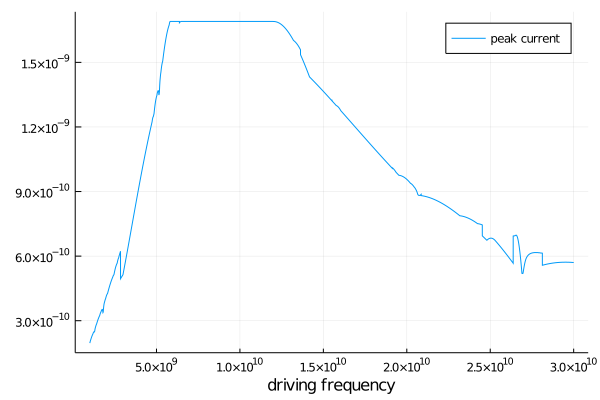

In [109]:
plot(qubit_ωs, qubit_peaks, label="peak current", xlabel="driving frequency")

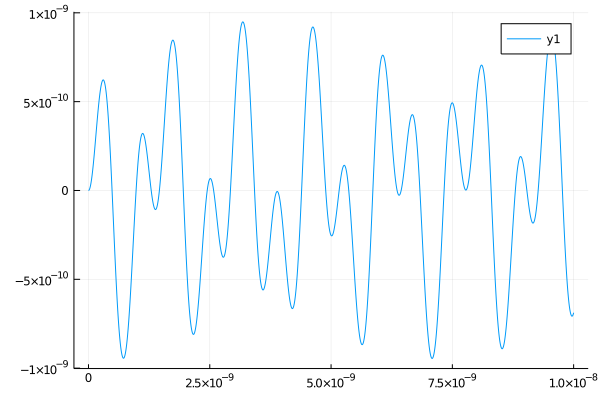

In [117]:
tspan = (0.0, 1e-8)
qubit_prob = SecondOrderODEProblem(qubit, [0.0 + 0.0im], [0.0 + 0.0im], tspan, 4.0e9)
qubit_sol = solve(qubit_prob, alg, dt=dt, reltol=1e-9, abstol=1e-9)
plot(qubit_sol.t, real.(qubit_sol[2,:]))